In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/research/qc_scaling/notebooks`


In [2]:
using Makie
using CairoMakie
using HDF5
using Glob
using Statistics
using ColorSchemes
using LsqFit

In [3]:
include("plotting_boilerplate.jl")

In [18]:
function compute_nstate0(nqubit)
    return Int(ceil(3^nqubit / (2^(nqubit-1) +1)))
end

function mutual_information(f)
   if f==1 || f==0
       return 1
   end
   return 1 - log(2, f) * log(2, 1-f)
end

function compute_nquantum(nqubit, nstate)
    return Int(nstate * nqubit)
end

function compute_nclassic(nqubit)
    return Int((3^nqubit - 1) / 2)
end
    
pzeros = 0:0.1:1
nqubit = 6
nclassic = compute_nclassic(nqubit)
nstate0 = compute_nstate0(nqubit)

23

In [23]:
filenames = glob("????????.h5", "/Users/jlazar/research/qc_scaling/data/$(nqubit)_qubit/*.h5");
# filenames = glob("????????.h5", "/Users/jlazar/research/qc_scaling/data/$(nqubit)_qubit_new/");

In [21]:
d = Dict()
for filename in filenames
    x = h5open(filename) do h5f
        nstate, pzero, maxacc = nothing, nothing, nothing
        if "results" in keys(h5f)
            nstate, pzero = attrs(h5f["results"])["nstate"], attrs(h5f["results"])["pzero"]
            maxacc = maximum(h5f["results/accuracies"][:])
        end
        nstate, pzero, maxacc
    end
    k = x[1], x[2]
    maxacc = x[3]
    if ~(k in keys(d))
        d[k] = []
    end
    push!(d[k], maxacc)
end

In [22]:
nstates = []
for (nstate, _) in keys(d)
    if nstate in nstates
        continue
    end
    push!(nstates, nstate)
end
sort!(nstates)

12-element Vector{Any}:
  67
  90
 113
 134
 157
 180
 201
 268
 335
 402
 469
 536

In [14]:
# out = f(())
out = Array{Float64}(undef, 11, length(nstates), 3)
for (idx, pzero) in enumerate(0:0.1:1)
    for (jdx, nstate) in enumerate(nstates)
        k = (nstate, pzero)
        if ~(k in keys(d))
            continue
        end
        res = d[k]
        out[idx, jdx, :] = quantile(res, [0.16, 0.5, 0.84])
   end
end

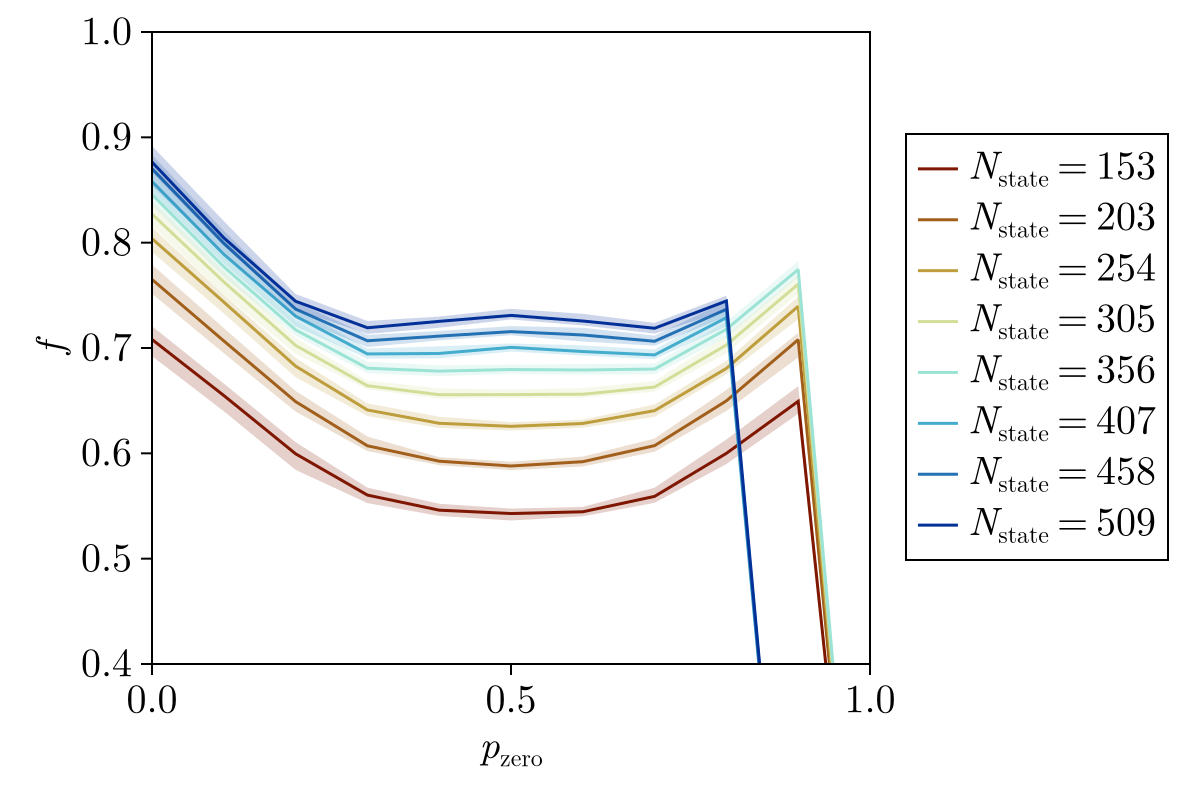

In [15]:
fig = Figure(size=(600, 400))
ax = Axis(
    fig[1, 1],
    limits=(0, 1, 0.4, 1),
    xlabel=L"p_{\mathrm{zero}}",
    ylabel=L"f"
)

colors = cgrad(:roma, length(nstates), categorical=true)

for (idx, (nstate, color)) in enumerate(zip(nstates, colors))
    lines!(ax, pzeros, out[:, idx, 2], label=L"N_{\mathrm{state}}=%$(nstate)", color=color)
    band!(ax, pzeros, out[:, idx, 1], out[:, idx, 3], color=(color, 0.2))
end

fig[1, 2] = Legend(fig, ax)

# save("../figures/f_vs_pzero_$(nqubit).pdf", fig)
fig

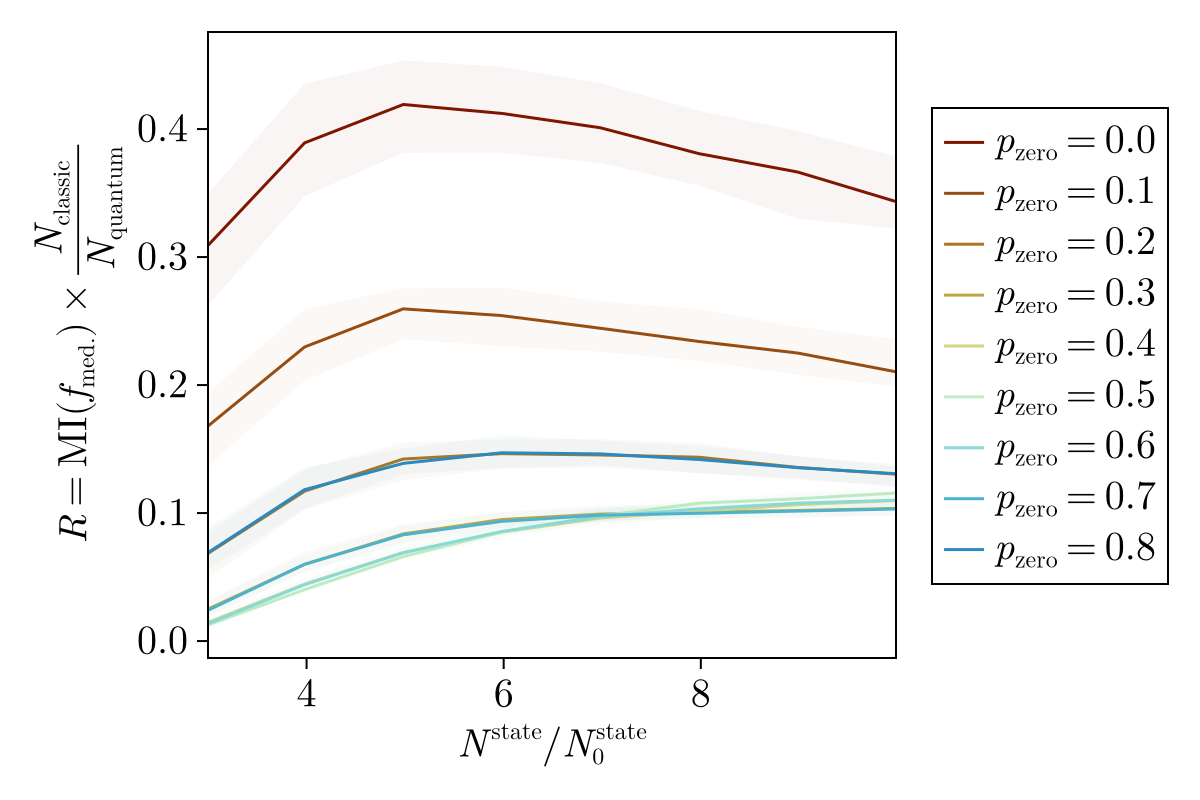

In [17]:
fig = Figure(size=(600, 400))
ax = Axis(
    fig[1, 1],
    limits=(nstates[1]/nstate0, nstates[end]/nstate0, nothing, nothing),
    xlabel=L"N^{\mathrm{state}} / N^{\mathrm{state}}_{0}",
    ylabel=L"R = \mathrm{MI}(f_{\mathrm{med.}}) \times \frac{N_{\mathrm{classic}}}{N_{\mathrm{quantum}}}",
)

colors = cgrad(:roma, length(pzeros), categorical=true)

pzeros = 0.0:0.1:0.8
for (idx, (color, pzero)) in enumerate(zip(colors, pzeros))
   lines!(
        ax,
        nstates ./ nstate0,
        mutual_information.(out[idx, :, 2]) ./ compute_nquantum.(nqubit, nstates) .* compute_nclassic(nqubit),
        color=color,
        label=L"p_{\mathrm{zero}} = %$(pzero)"
    )
    
    band!(
        ax,
        nstates ./ nstate0,
        mutual_information.(out[idx, :, 1]) ./ compute_nquantum.(nqubit, nstates) .* compute_nclassic(nqubit),
        mutual_information.(out[idx, :, 3]) ./ compute_nquantum.(nqubit, nstates) .* compute_nclassic(nqubit),
        color=color,
        alpha=0.2
#         label=L"p_{\mathrm{zero}} = %$(pzero)"
    )
end

fig[1, 2] = Legend(fig, ax)

# save("../figures/R_vs_Nstate_$(nqubit).pdf", fig)
fig

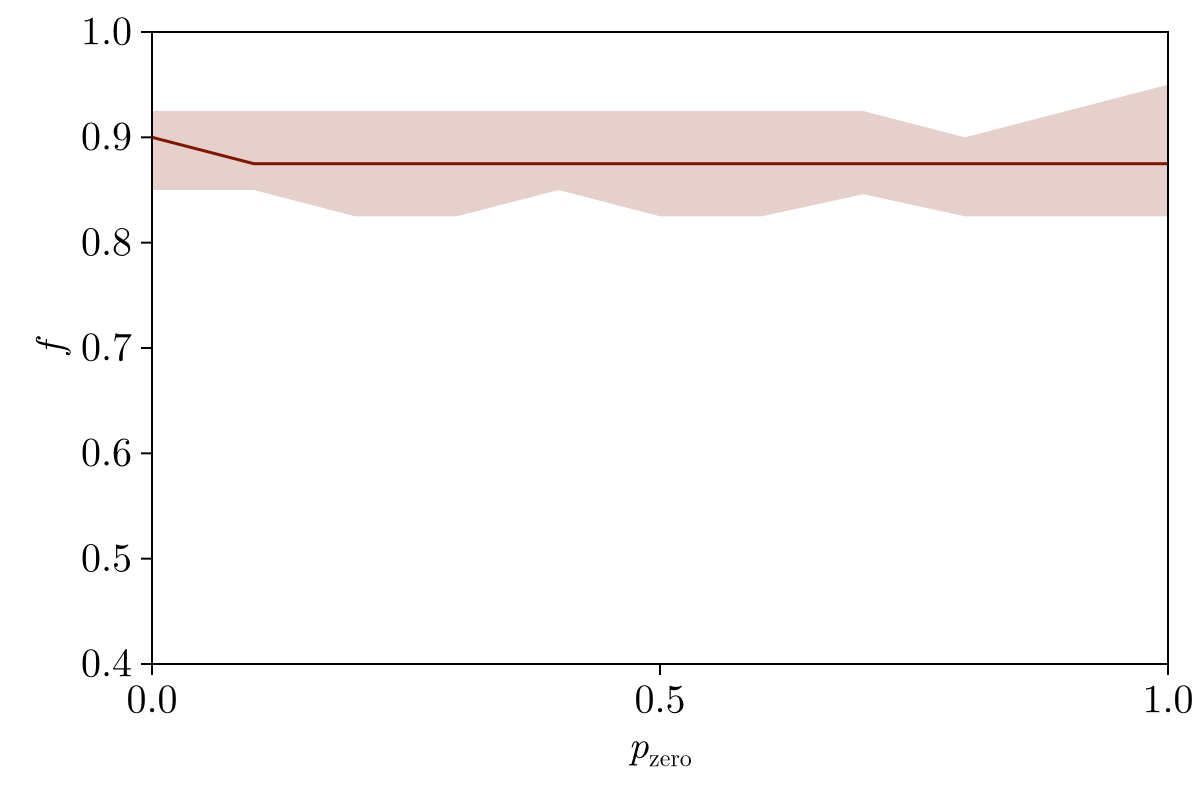

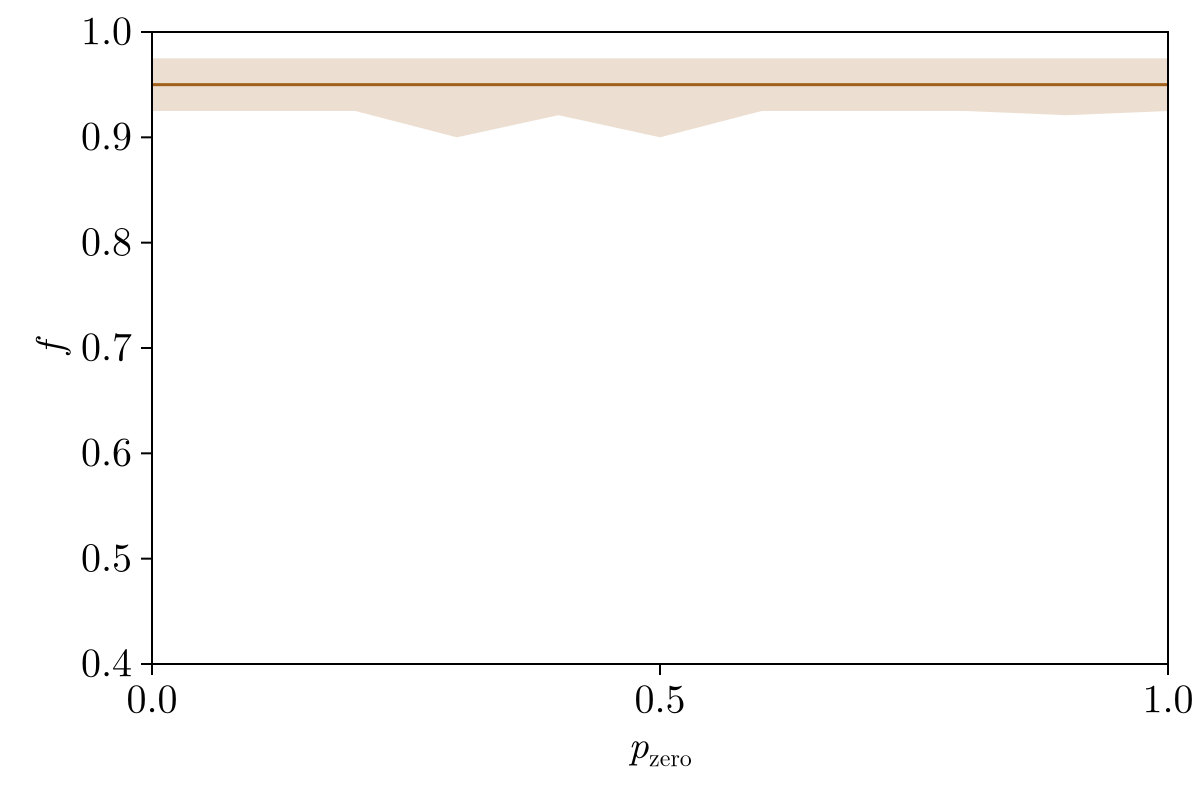

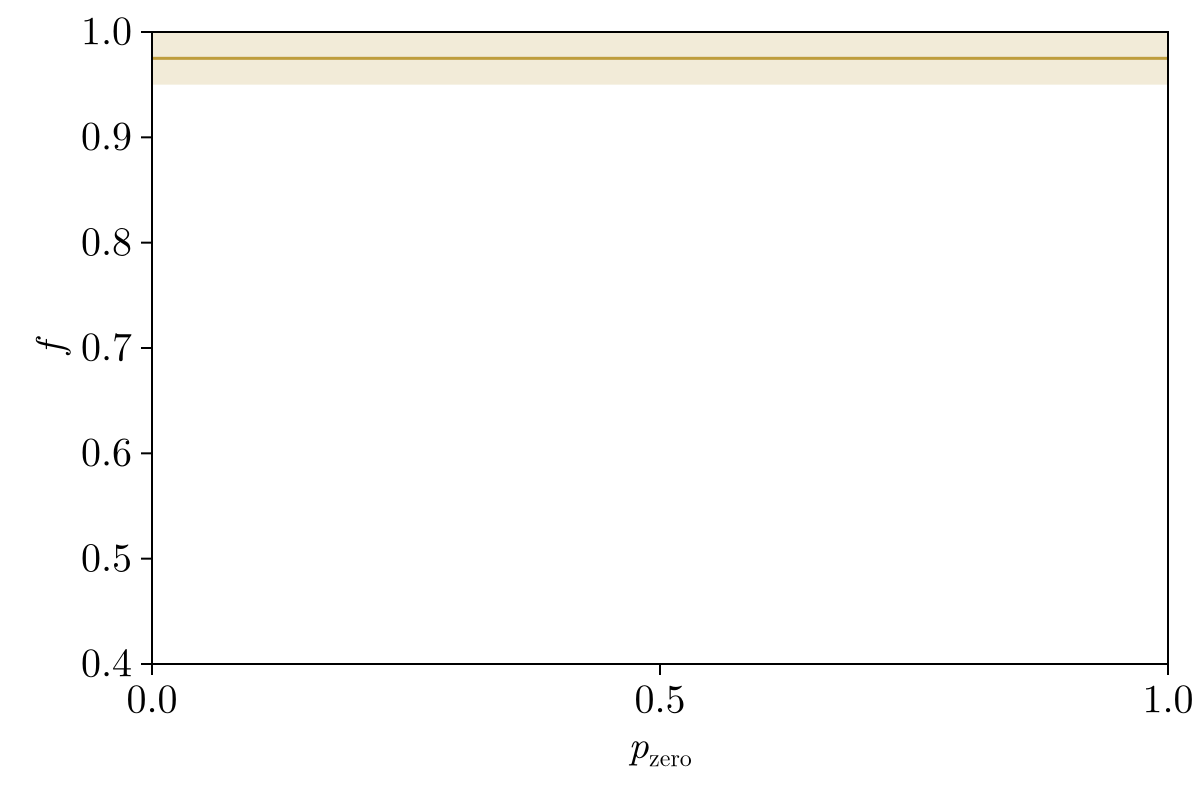

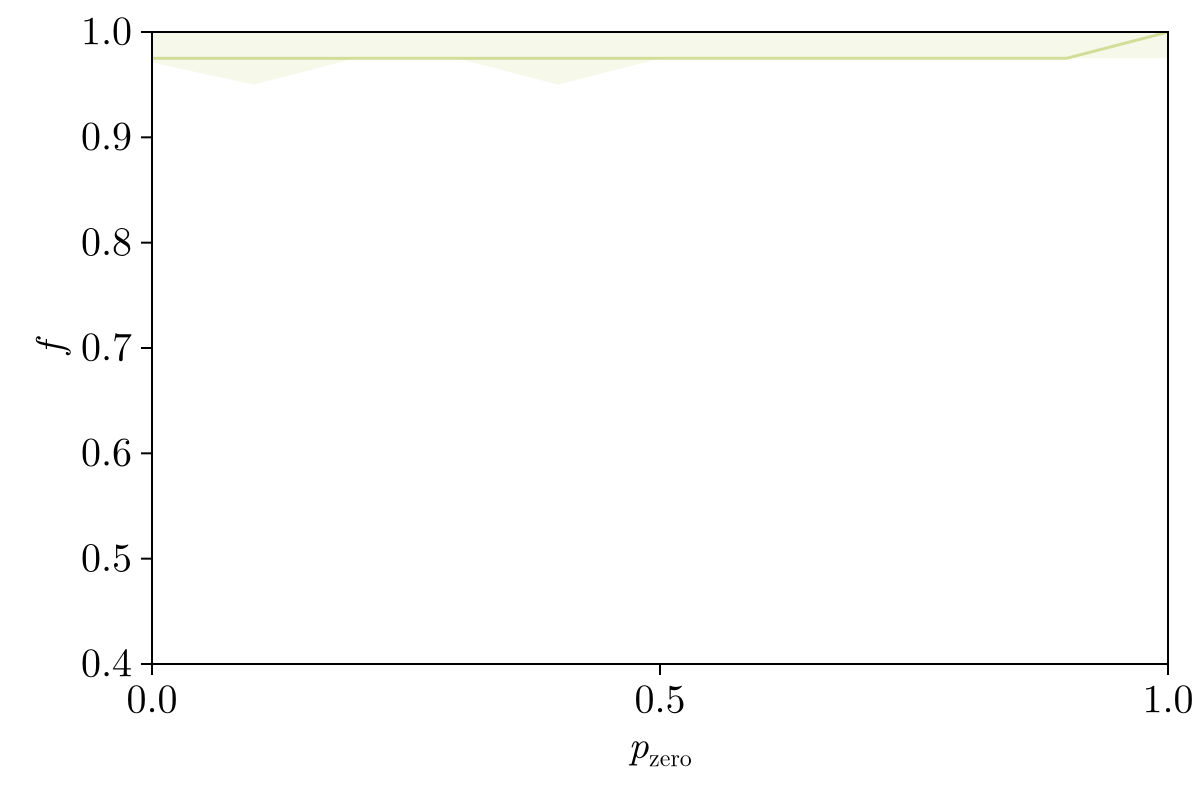

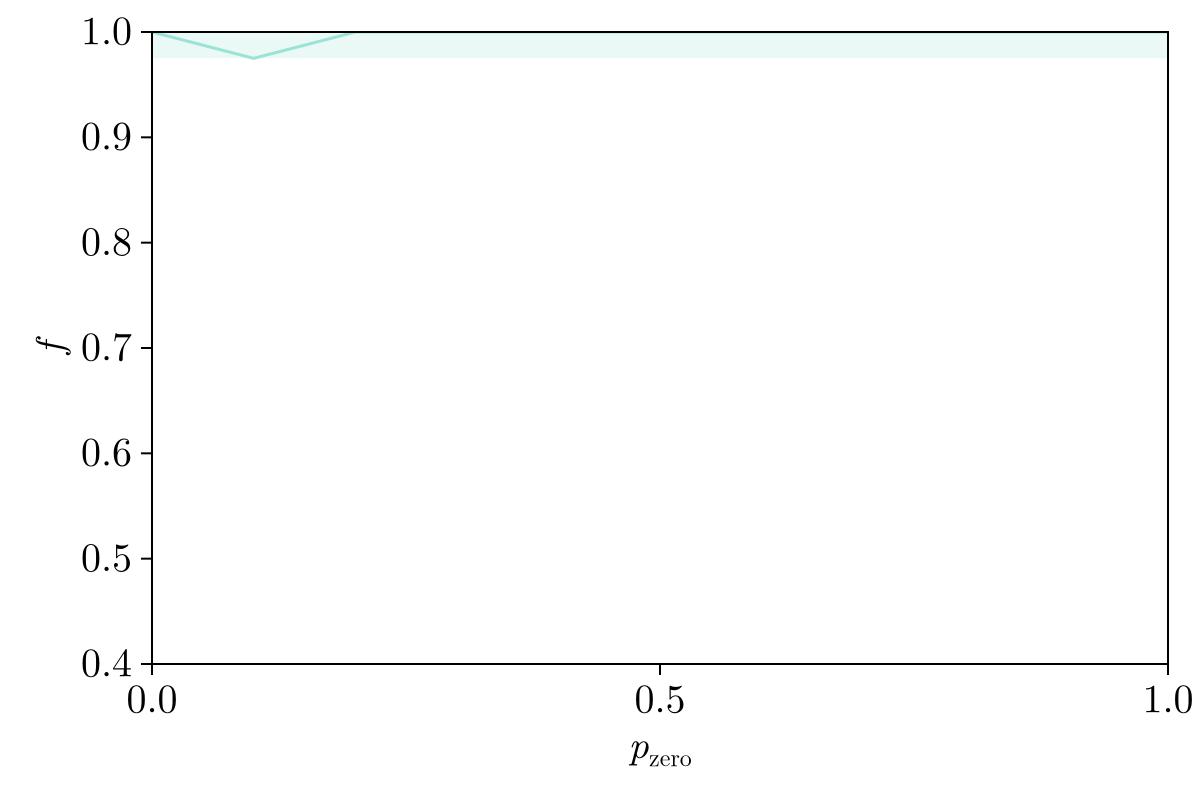

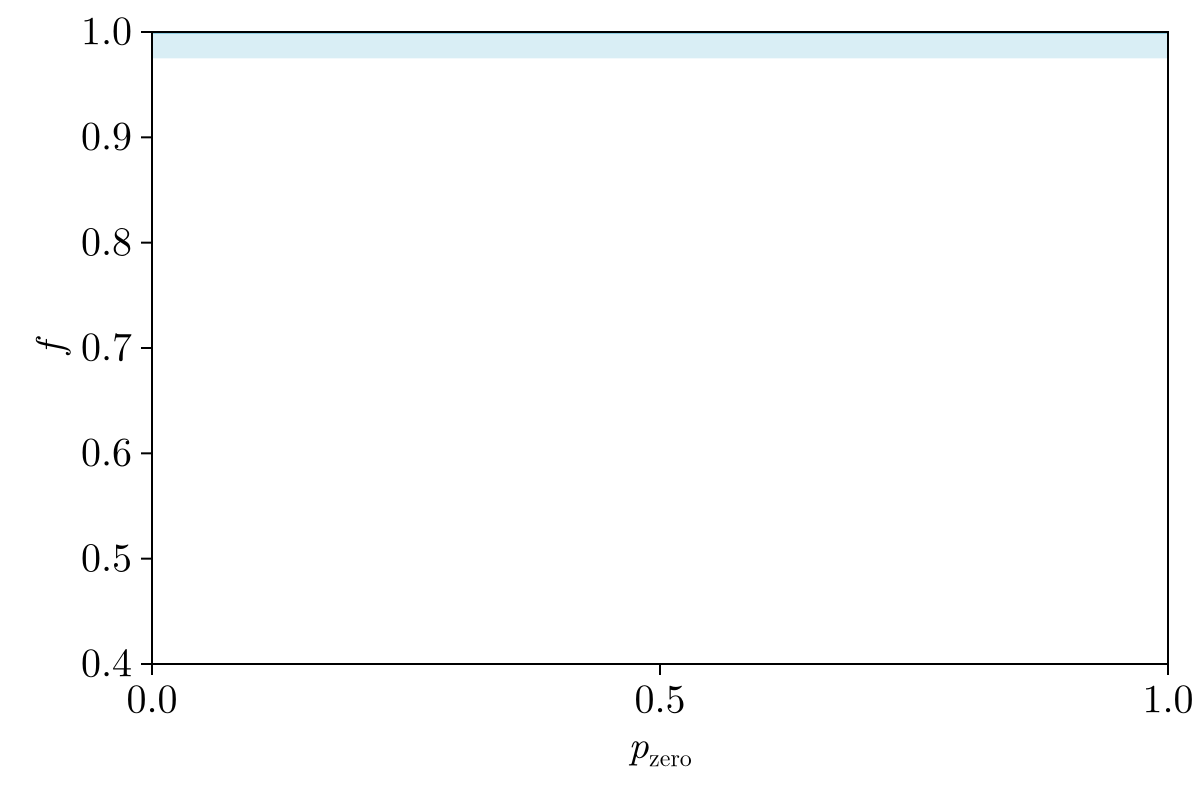

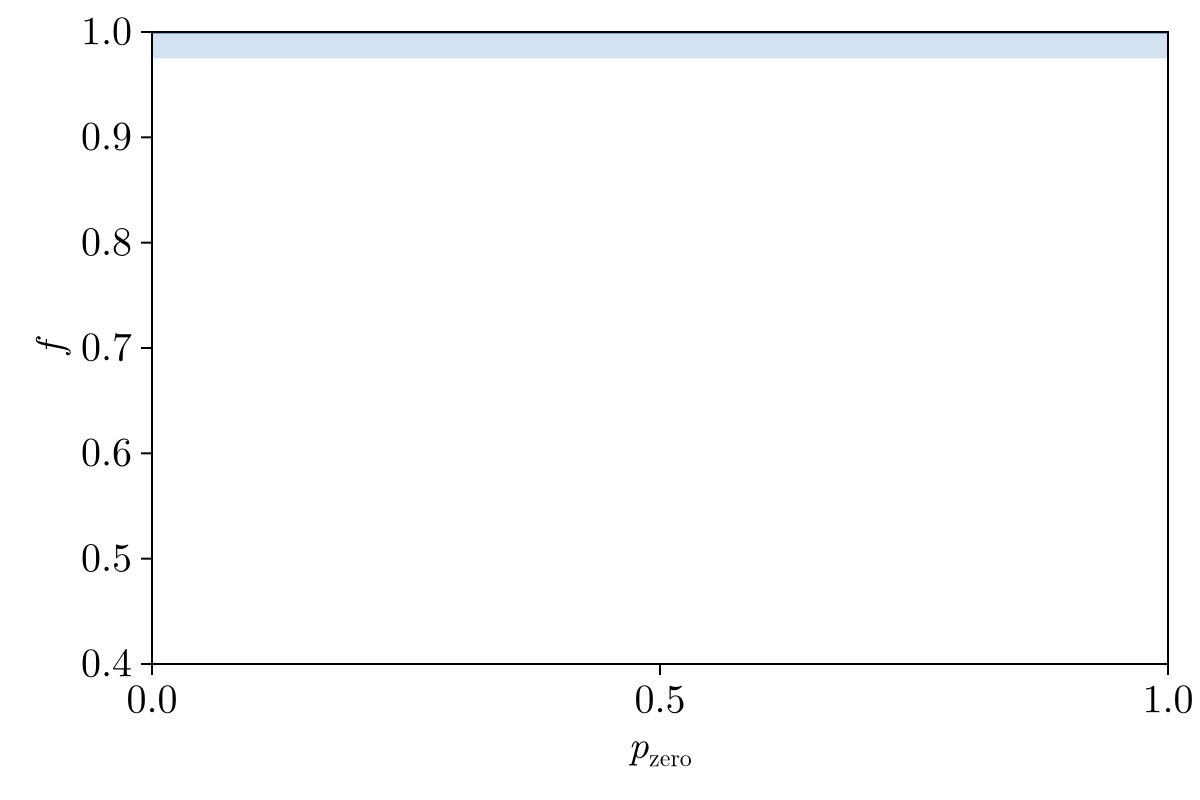

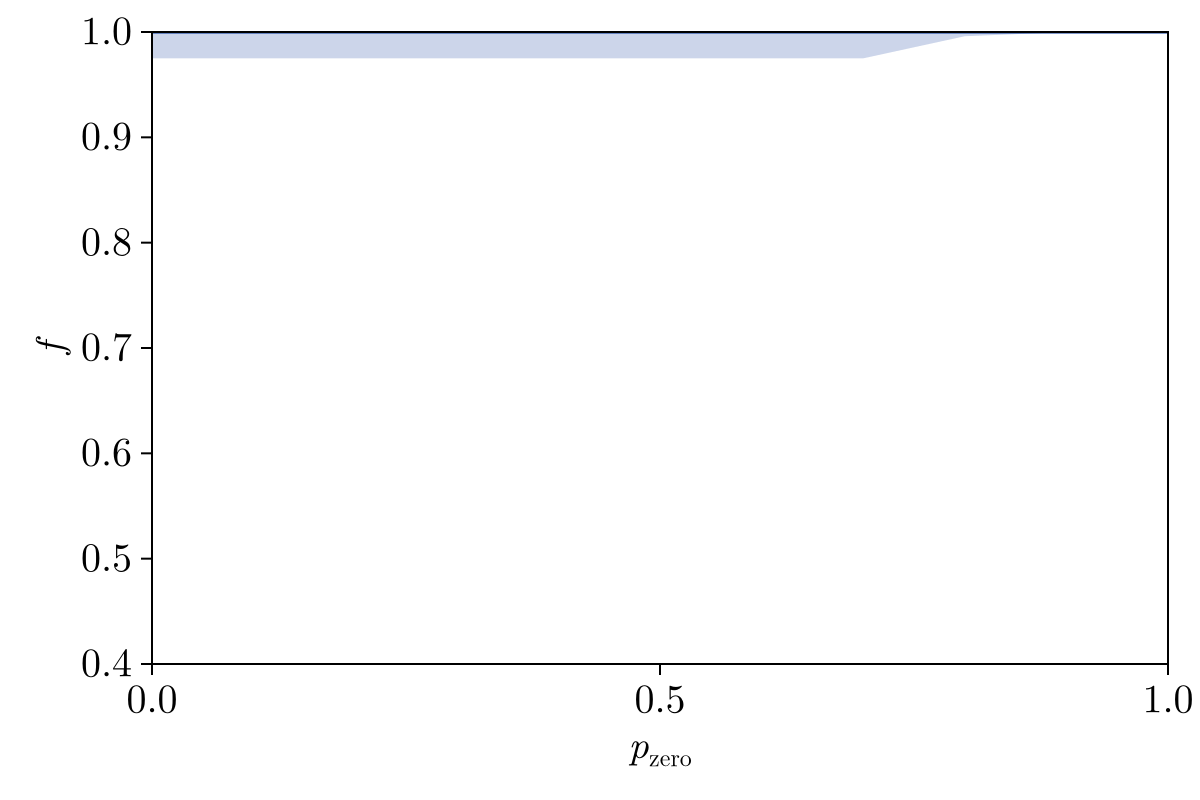

In [101]:
colors = cgrad(:roma, length(nstates), categorical=true)

for (idx, (nstate, color)) in enumerate(zip(nstates, colors))
    fig = Figure(size=(600, 400))
    ax = Axis(
        fig[1, 1],
        limits=(0, 1, 0.4, 1),
        xlabel=L"p_{\mathrm{zero}}",
        ylabel=L"f"
    )
    lines!(ax, pzeros, out[:, idx, 2], label=L"N_{\mathrm{state}}=%$(nstate)", color=color)
    band!(ax, pzeros, out[:, idx, 1], out[:, idx, 3], color=(color, 0.2))
    display(fig)
end

# fig[1, 2] = Legend(fig, ax)

# save("../figures/f_vs_pzero_$(nqubit).pdf", fig)
# fig

In [21]:
fig = Figure()
ax = Axis(fig[1, 1])

xs = 0:0.01:5

lines!(ax, xs, sigmoid.(xs.-1.5, 0.0001) - sigmoid.(xs .- 3.3, 0.0001), label="Discrete")
lines!(ax, xs, sigmoid.(xs.-1.5, 0.05) - sigmoid.(xs .- 3.3, 0.05), label="Smoothed")
lines!(ax, xs, sigmoid.(xs.-1.5, 0.1) - sigmoid.(xs .- 3.3, 0.1), label="Very smooth")

axislegend(ax)

fig

LoadError: UndefVarError: `sigmoid` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [20]:
pzero = 1.0
accuracies = Array{Float64}(undef, 100, length(nstates), 10_000)

colors = cgrad(:roma, length(nstates), categorical=true)

fig = Figure()
ax = Axis(
    fig[1,1],
    limits=(0, 10_000, nothing, nothing)
)

for (jdx, nstate) in enumerate(nstates)
    @show nstate
    idx = 0
    for filename in filenames
        x = h5open(filename) do h5f
            attrs(h5f["results"])["nstate"], attrs(h5f["results"])["pzero"], h5f["results/accuracies"][:]
        end
        if x[1]!=nstate || x[2]!=pzero
            continue
        end
        idx += 1
        accuracies[idx, jdx, :] = x[3]

    end
    accs = accuracies[1:idx, jdx, :]
    median_accs = median(accs, dims=1)[1, :]
    lines!(
        ax,
        1:size(accs)[2],
        median_accs,
        color=colors[jdx],
        label=L"N_{\mathrm{state}}=%$(nstate)"
    )
end

fig[1, 2] = Legend(fig, ax)
fig

nstate = 153


LoadError: unable to determine if /Users/jlazar/research/qc_scaling/data/6_qubit/29108538.h5 is accessible in the HDF5 format (file may not exist)

In [205]:
median(accuracies[:, 1, :], dims=1)[1, :]

10000-element Vector{Float64}:
 0.28323170731707314
 0.28490853658536586
 0.2871951219512195
 0.28871951219512193
 0.2910060975609756
 0.2934451219512195
 0.29527439024390245
 0.2974085365853658
 0.2995426829268293
 0.30076219512195124
 0.30335365853658536
 0.3053353658536585
 0.3077743902439024
 ⋮
 0.6472560975609756
 0.6472560975609756
 0.6472560975609756
 0.6472560975609756
 0.6472560975609756
 0.6472560975609756
 0.6481707317073171
 0.6486280487804879
 0.6486280487804879
 0.6486280487804879
 0.6486280487804879
 0.6486280487804879

In [10]:
pzero = 1.0
accuracies = Array{Float64}(undef, 100, length(nstates), 10_000)
for (jdx, nstate) in enumerate(nstates)
    idx = 0
    for filename in filenames
        x = h5open(filename) do h5f
            attrs(h5f["results"])["nstate"], attrs(h5f["results"])["pzero"], h5f["results/accuracies"][:]
        end
    #     println()
        if x[1]!=nstate || x[2]!=pzero
            continue
        end
        idx += 1
        accuracies[idx, jdx, :] = x[3]

    end
    @show 4
end

4 = 4
4 = 4
4 = 4
4 = 4
4 = 4
4 = 4
4 = 4
4 = 4


In [14]:
model(40000, fit.param)

0.6654604116732319

In [29]:
ydata

🔢 HDF5.Dataset: (invalid)

fit.param = [1.5500319699963475e-6, 0.6034591328733779]


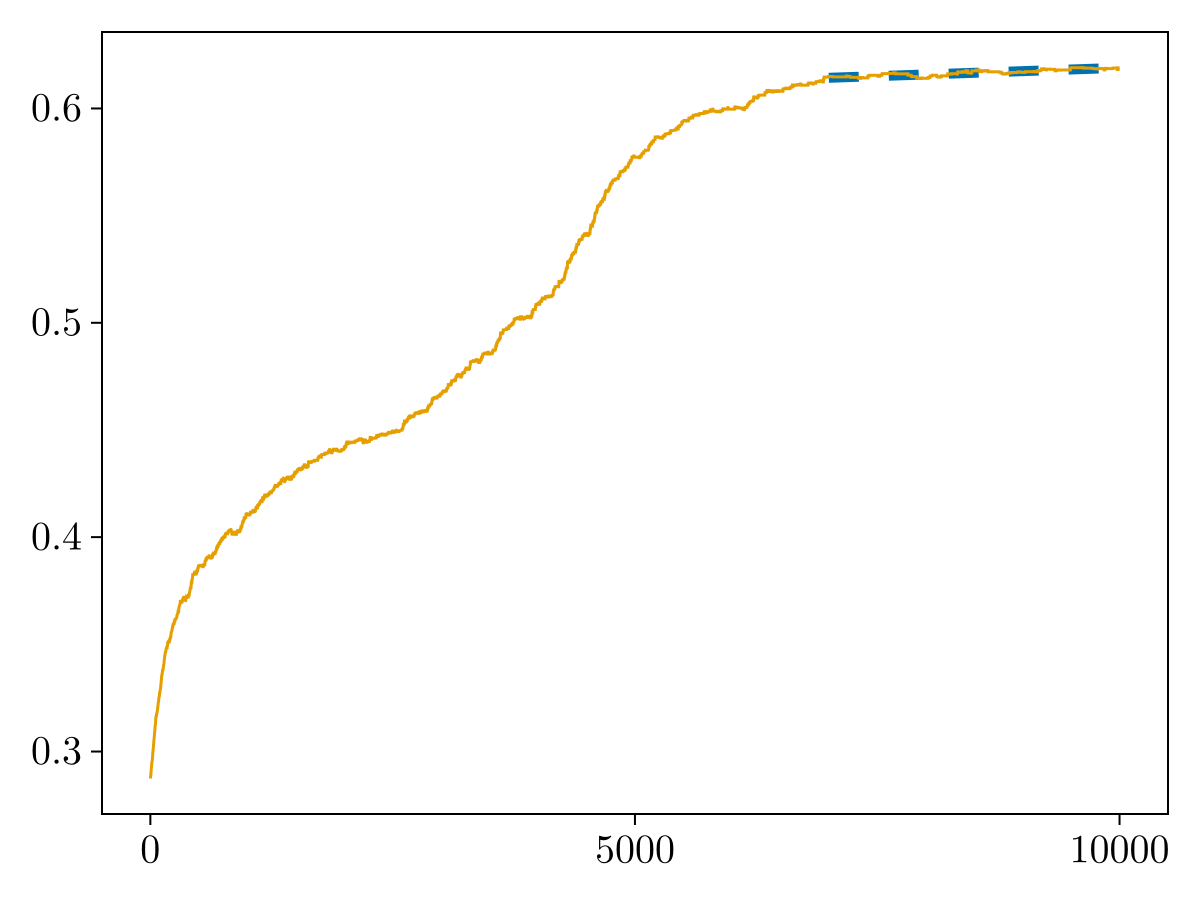

In [30]:
x = h5open("/Users/jlazar/Downloads/testing.h5") do h5f
    @. model(x, p) = p[1] * x + p[2]
    xdata = 7_000:10_000
    ydata = h5f["results_4/accuracies"][:]
    p0 = [0, 0.7]
    fit = curve_fit(model, xdata, ydata[7_000:10_000], p0)
    fit, ydata
end

fit, ydata = x
@show fit.param

fig = Figure()
ax = Axis(fig[1, 1])

lines!(ax, xdata, model(xdata, fit.param), linewidth=5, linestyle=:dash)
lines!(ax, 1:10000, ydata)

fig

In [25]:
for idx in 1:length(nstates)
    @. model(x, p) = p[1] * x + p[2]
    xdata = 5_000:10_000
    m = accuracies[:, idx, 1].>0
    ydata = median(accuracies[m, idx, :], dims=1)[1, 5000:end]
    p0 = [0, 0.7]
    fit = curve_fit(model, xdata, ydata, p0)
    @show nstates[idx]
    @show fit.param
end

LoadError: ArgumentError: median of an empty array is undefined, Float64[]

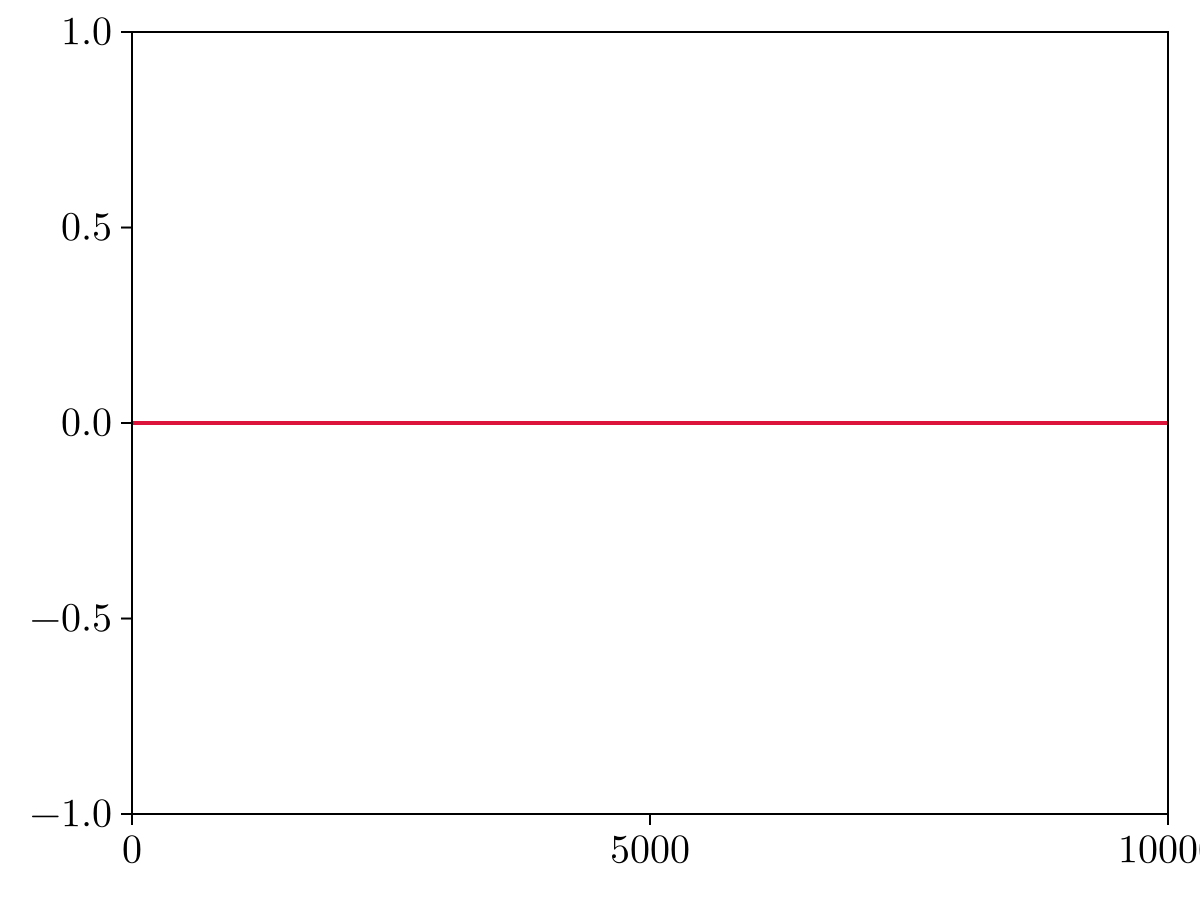

In [24]:
fig = Figure()
ax = Axis(
    fig[1,1],
    limits=(0, 10_000, nothing, nothing)
)

for (jdx, nstate) in enumerate(nstates)
    lines!(ax, 1:size(accuracies)[3], median(accuracies, dims=1)[:, jdx, :][1, :], color=:crimson)
end

fig

In [159]:
# fig = Figure()
# ax = Axis(
#     fig[1,1],
#     limits=(0, 10_000, nothing, nothing)
# )

# for idx in 1:size(accuracies)[1]
#     lines!(ax, 1:size(accuracies)[3], accuracies[idx, 1, :], color=:black, alpha=0.1)
# end

# lines!(ax, 1:size(accuracies)[3], median(accuracies, dims=1)[:, 1, :], color=:crimson)

# fig

LoadError: ArgumentError: 
    Conversion failed for Lines (With conversion trait PointBased()) with args:
        Tuple{UnitRange{Int64}, Matrix{Float64}} 
    Got converted to: Tuple{UnitRange{Int64}, Matrix{Float64}}
    Lines requires to convert to argument types Tuple{AbstractVector{<:Union{Point2, Point3}}}, which convert_arguments didn't succeed in.
    To fix this overload convert_arguments(P, args...) for Lines or PointBased() and return an object of type Tuple{AbstractVector{<:Union{Point2, Point3}}}.`


In [35]:
function linear_regression(x, y) where T<:Real
# function linear_regression(x::Vector{T}, y::Vector{T}) where T<:Real
    # Check that x and y have the same length
    length(x) == length(y) || throw(DimensionMismatch("x and y must have the same length"))
    
    n = length(x)
    
    # Construct the design matrix X
    X = [ones(n) x]
    
    # Compute X'X and X'y
    XtX = X' * X
    Xty = X' * y
    
    # Solve the normal equations: (X'X)β = X'y
    β = XtX \ Xty  # This uses Julia's built-in solver which is more stable than explicit inversion
    
    # Return the intercept (b) and slope (m)
    return β
end

linear_regression (generic function with 2 methods)

In [64]:
linear_regression(1:1000, ydata[end-999:end])

2-element Vector{Float64}:
 0.617433266283498
 1.6681087674056995e-6

In [77]:
x = 1:10000
y = ydata

maxlen = 2000
slopes = []
for idx in 2:10_000
    start = maximum([idx-maxlen+1, 1])
    x = start:idx
    y = ydata[start:idx]
    intercept, slope = linear_regression(x, y)
    push!(slopes, slope)
end

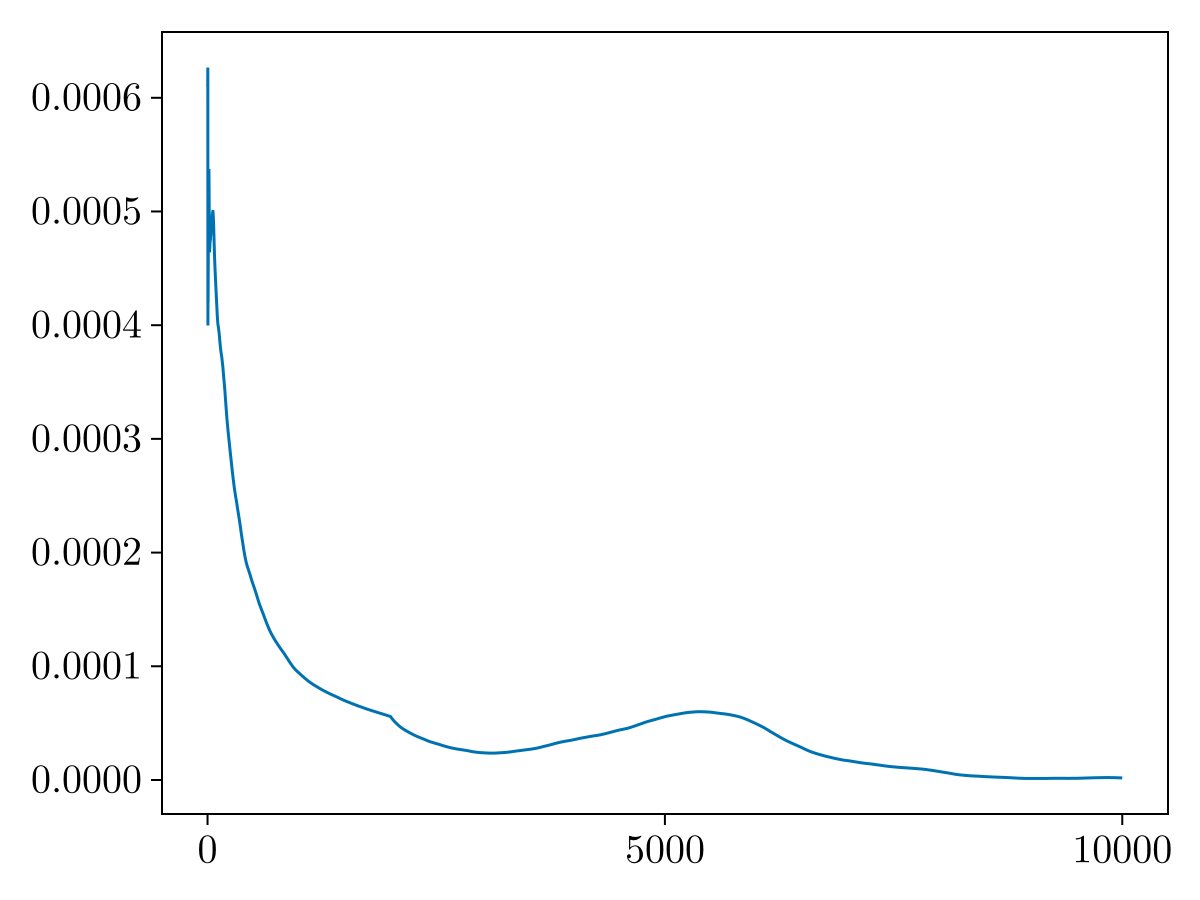

In [78]:
fig = Figure()
ax = Axis(
    fig[1, 1],
#     yscale=:log10
)

lines!(ax, 2:10_000, slopes)

fig

In [85]:
filenames = glob("????????.h5", "/Users/jlazar/research/qc_scaling/data/$(nqubit)_qubit/");

In [104]:
maxlen = 3000
for filename in filenames
    @show filename
    ydata = h5open("/Users/jlazar/Downloads/testing.h5") do h5f
        ydata = h5f["results/accuracies"][:]
    end
    slopes = []
    for idx in 2:10_000
        start = maximum([idx-maxlen+1, 1])
        x = start:idx
        y = ydata[start:idx]
        intercept, slope = linear_regression(x, y)
        push!(slopes, slope)
    end
    println(findall(slopes.<0))
end

filename = "/Users/jlazar/research/qc_scaling/data/6_qubit/29090188.h5"


LoadError: BoundsError: attempt to access 100-element Vector{Float64} at index [1:101]

In [112]:
using ProgressBars

In [123]:
maxaccs, cuts = [], []

idx = 0
for filename in filenames
    
#     fig = Figure()
#     ax = Axis(
#         fig[1, 1],
#         limits=(2, 10000, 0, 1e-4)
#     )
    
    ydata = h5open(filename) do h5f
        ydata = h5f["results/accuracies"][:]
    end
    slopes = []
    for idx in maxlen:10_000
        start = maximum([idx-maxlen+1, 1])
        x = start:idx
        y = ydata[start:idx]
        intercept, slope = linear_regression(x, y)
        push!(slopes, slope)
    end
    
    x = findall(slopes .< 0)
    y = length(x) > 0 ? minimum(x) : 10_000
    push!(cuts, y)
    push!(maxaccs, argmax(ydata))
        
    idx += 1
    if mod(idx, 100)==0
        println(idx)
    end
    
#     lines!(ax, maxlen:10_000, slopes)
# #     lines!(ax, [2, 10_000], [0, 0])
#     vlines!(ax, [argmax(ydata)], color=:crimson)
#     display(fig)
end

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700


LoadError: InterruptException:

In [115]:
maxaccs

846-element Vector{Any}:
 0.7967032967032966
 0.9038461538461539
 0.945054945054945
 0.9230769230769231
 0.9368131868131868
 0.9587912087912088
 0.9697802197802198
 0.9532967032967034
 0.7362637362637363
 0.8461538461538461
 0.8846153846153846
 0.8901098901098901
 0.8983516483516484
 ⋮
 0.967032967032967
 0.945054945054945
 0.9532967032967034
 0.9587912087912088
 0.9587912087912088
 0.967032967032967
 0.967032967032967
 0.9560439560439561
 0.9505494505494505
 0.9615384615384616
 0.9752747252747253
 0.9505494505494505

In [114]:
cuts

846-element Vector{Any}:
  5615
  1886
  4978
  1813
  1648
  3711
  3530
   192
  3366
  1169
   872
 10000
   199
     ⋮
   319
   509
   345
   315
   915
  4305
   565
  4359
  1522
   528
  2243
   408

In [118]:
Pkg.add("FHist")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed FHist ──────── v0.11.15
   Installed Measurements ─ v2.14.0
    Updating `~/research/qc_scaling/notebooks/Project.toml`
  [68837c9b] + FHist v0.11.15
    Updating `~/research/qc_scaling/notebooks/Manifest.toml`
  [000d9b38] + BayesHistogram v1.0.7
  [49dc2e85] + Calculus v0.5.2
  [68837c9b] + FHist v0.11.15
  [eff96d63] + Measurements v2.14.0
  [3cdcf5f2] + RecipesBase v1.3.4
Precompiling project...
   4931.5 ms  ✓ Measurements
    916.8 ms  ✓ Measurements → MeasurementsRecipesBaseExt
    960.7 ms  ✓ Measurements → MeasurementsUnitfulExt
   1079.7 ms  ✓ Measurements → MeasurementsSpecialFunctionsExt
   4151.2 ms  ✓ FHist
   9053.7 ms  ✓ Distributions → DistributionsTestExt
   6997.0 ms  ✓ FHist → FHistHDF5Ext
 137334.0 ms  ✓ Measurements → MeasurementsMakieExt
 137506.3 ms  ✓ FHist → FHistMakieExt
  9 dependencies successfully precompiled in 164 seconds. 314 already precompiled.


In [120]:
using FHist

In [134]:
h = Hist2D((maxaccs, cuts); binedges=(0:500:10000, 0:1000:10000))

edges: ([0.0, 500.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0, 4000.0, 4500.0  …  5500.0, 6000.0, 6500.0, 7000.0, 7500.0, 8000.0, 8500.0, 9000.0, 9500.0, 10000.0], [0.0, 1000.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000.0])
bin counts: [5.0 1.0 … 0.0 0.0; 231.0 18.0 … 0.0 0.0; … ; 56.0 41.0 … 0.0 0.0; 88.0 58.0 … 0.0 0.0]
total count: 3571.0

In [135]:
h.bincounts

20×10 Matrix{Float64}:
   5.0    1.0   2.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0
 231.0   18.0   9.0   2.0   0.0   0.0   2.0  0.0  0.0  0.0
 312.0   22.0  12.0   8.0   1.0   0.0   0.0  0.0  0.0  0.0
 239.0   52.0   7.0   2.0   1.0   1.0   0.0  0.0  0.0  0.0
 151.0   96.0   4.0   5.0   2.0   4.0   0.0  0.0  0.0  0.0
  52.0  100.0  26.0   6.0   0.0   1.0   0.0  0.0  0.0  0.0
  22.0   67.0  60.0   6.0   3.0   1.0   0.0  0.0  0.0  0.0
  22.0   34.0  60.0  23.0   3.0   2.0   0.0  0.0  0.0  0.0
  35.0   13.0  44.0  36.0   7.0   1.0   2.0  0.0  0.0  0.0
  29.0    8.0  18.0  31.0  27.0   3.0   2.0  0.0  0.0  0.0
  35.0   24.0  13.0  34.0  28.0   5.0   0.0  0.0  0.0  0.0
  34.0   19.0  12.0  19.0  29.0  15.0   6.0  0.0  0.0  0.0
  43.0   18.0  18.0  10.0  19.0  14.0   6.0  0.0  0.0  0.0
  43.0   31.0  25.0  11.0  19.0  13.0  14.0  0.0  0.0  0.0
  44.0   31.0  20.0  10.0   6.0  20.0  13.0  0.0  0.0  0.0
  52.0   32.0  31.0  18.0  11.0  17.0  11.0  0.0  0.0  0.0
  38.0   26.0  15.0  15.0  13.0  

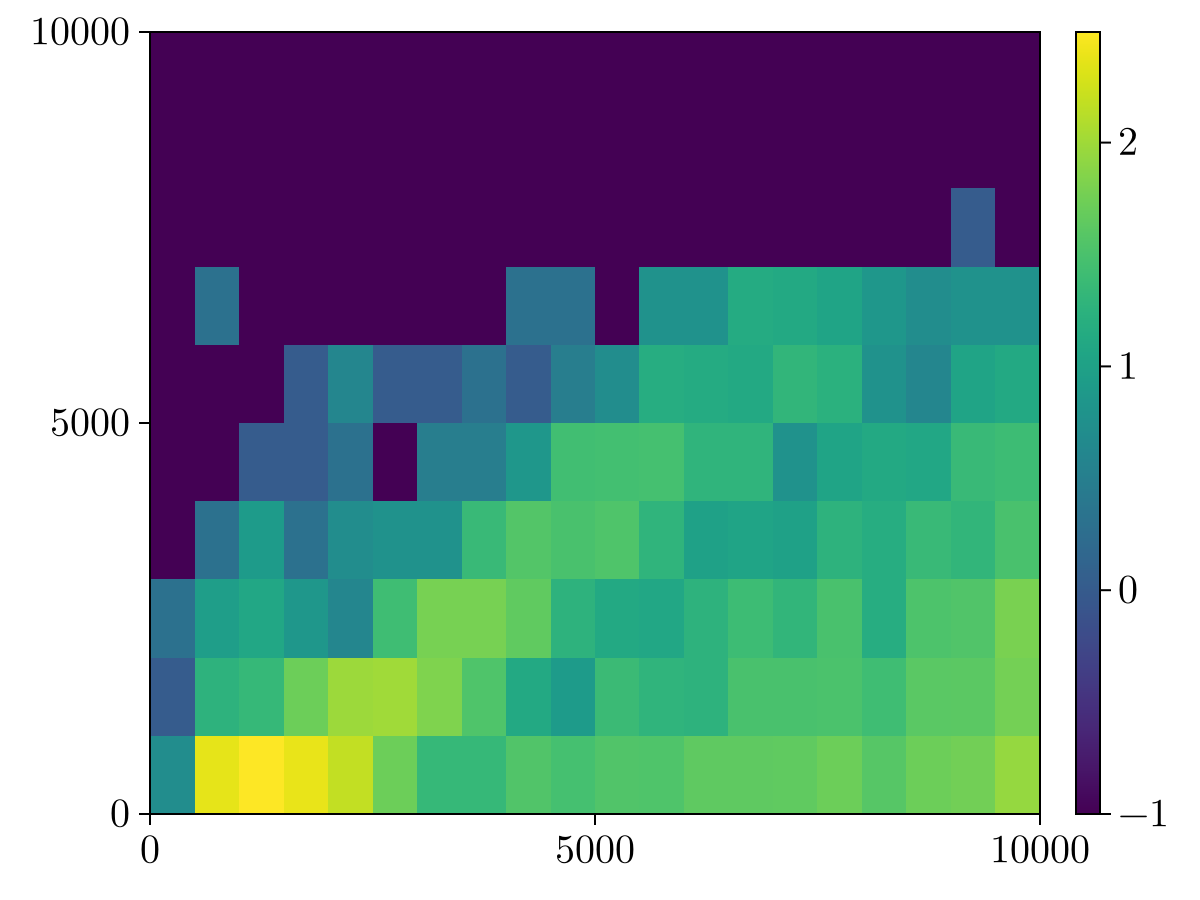

In [142]:
# fig = Figure()
# ax = Axis(fig[1, 1])

fig, ax, hm1 = heatmap(
    h.binedges[1],
    h.binedges[2],
    log.(10, h.bincounts),
    colorrange=(-1, log(10, maximum(h.bincounts)))
)

Colorbar(fig[:, end+1], hm1)

fig

In [129]:
log.(10, h.bincounts)

10×11 Matrix{Float64}:
 2.37291  1.27875  1.04139  0.30103  …  -Inf   -Inf  -Inf  0.0
 2.74115  1.86923  1.27875  1.0         -Inf   -Inf  -Inf  0.0
 2.3075   2.29226  1.47712  1.04139     -Inf   -Inf  -Inf  0.30103
 1.64345  2.00432  2.07918  1.4624      -Inf   -Inf  -Inf  0.69897
 1.80618  1.32222  1.79239  1.82607     -Inf   -Inf  -Inf  0.0
 1.83885  1.63347  1.39794  1.72428  …  -Inf   -Inf  -Inf  0.90309
 1.9345   1.6902   1.63347  1.32222     -Inf   -Inf  -Inf  1.04139
 1.98227  1.79934  1.70757  1.44716     -Inf   -Inf  -Inf  1.32222
 1.95424  1.81954  1.68124  1.57978     -Inf   -Inf  -Inf  1.6721
 2.15836  1.99564  1.98677  1.70757       0.0  -Inf  -Inf  1.90849